# **Programming Assessment \#4**

Names:

Gonzales, Mark Edward M. <br>
Lee, Hylene Jules G. <br>
Ong, Phoebe Clare L.

Group 13

More information on the assessment is found in our Canvas course. Link: https://dlsu.instructure.com/courses/93383/assignments/739602

<hr>

The following libraries and modules — all of which are automatically bundled with an Anaconda installation — were used in this notebook:

Library/Module | Description | License
:-- | :-- | :--
<a href = "https://docs.python.org/3/library/re.html">`re`</a> | Provides regular expression matching operations similar to those found in Perl | Python Software Foundation License
<a href = "https://docs.python.org/3/library/collections.html">`collections`</a> | Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers | Python Software Foundation License
<a href = "https://docs.python.org/3/library/collections.html">`pickle`</a> | Implements binary protocols for serializing and de-serializing a Python object structure | Python Software Foundation License
<a href = "https://www.nltk.org/">`nltk`</a> | Suite of open-source Python modules and data sets supporting research and development in natural language processing | Apache License 2.0
<a href = "https://pandas.pydata.org/">`pandas`</a> | Provides functions for data analysis and manipulation	 | BSD 3-Clause "New" or "Revised" License

*The descriptions were lifted from their respective websites.*

In [1]:
import re
from collections import Counter
import pickle

import nltk
import pandas as pd

# A. Loading the Corpus

*The code for loading the corpus (and its tokens) was taken from the provided notebook `Using_All_Project_Gutenberg_Documents_in_NLTK.ipynb`.*

Download NLTK's selection of texts taken from the Project Gutenberg electronic text archive.

In [2]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

To investigate the effect of case folding (i.e., converting all the words to lowercase) vis-à-vis case preservation, two spelling correction models are created. In this regard, a counter is created to store the frequencies of all the words upon conversion to lowercase. This will be used in building the (unigram) language model.

In [3]:
all_words_lowercase = Counter()

for filename in nltk.corpus.gutenberg.fileids():
    words = [word.lower() for word in nltk.corpus.gutenberg.words(filename)]
    all_words_lowercase.update(words)

Similarly, a counter is created to store the frequencies of all the words without converting them to lowercase.

In [4]:
all_words = Counter()

for filename in nltk.corpus.gutenberg.fileids():
    words = [word for word in nltk.corpus.gutenberg.words(filename)]
    all_words.update(words)

<hr>

# B. Computing the Probabilities

The code segments below deal with the computation of the probabilities related to the unigram language and error models.

## 1. Unigram Language Model

This function computes and returns the probability related to the prior knowledge of a given candidate word in a unigram language model. Following the convention in NLP1000, the return value of this method corresponds to $P(c)$.

**Parameters:**
- `word` (string): Candidate word
- `is_lowercase` (Boolean) : `True` if the spelling correction model performs lowercase conversion; `False`, otherwise

**Return Value:**
- Float: Probability related to the prior knowledge of a given candidate word in a unigram language model

In [5]:
def get_word_probability(word, is_lowercase):    
    if (is_lowercase):
        frequency = all_words_lowercase[word]
        probability = frequency / sum(all_words_lowercase.values())
    else:
        frequency = all_words[word]
        probability = frequency / sum(all_words.values())
    
    return probability

Precompute the probabilities related to the prior knowledge of all the words in the Project Gutenberg corpus. The rationale is to avoid the expensive $O(n)$ recomputation (where $n$ is the number of tokens) if the spelling correction program is used repeatedly (e.g., during testing).

In [6]:
word_probabilities_lowercase = {}
for candidate in all_words_lowercase:
    word_probabilities_lowercase[candidate] = get_word_probability(candidate, is_lowercase=True)
    
word_probabilities = {}
for candidate in all_words:
    word_probabilities[candidate] = get_word_probability(candidate, is_lowercase=False)

## 2. Error Model

This function counts the total number of occurrences of the given sequence of characters. 

**Parameters:**
- `character` (string): Sequence of characters 
- `is_lowercase` (Boolean): `True` if the spelling correction model performs lowercase conversion; `False`, otherwise

**Return Value:**
- Integer: Total number of occurrences of the given sequence of characters

In [7]:
def get_character_count(character, is_lowercase):    
    total_count = 0
    regex = re.compile(character)

    if (is_lowercase):
        for key, value in all_words_lowercase.items():
            num_occurrences = len(regex.findall(key))
            total_count += value * num_occurrences
    
    else:
        for key, value in all_words.items():
            num_occurrences = len(regex.findall(key))
            total_count += value * num_occurrences
    
    return total_count

The script below creates a dictionary for the error model derived from Peter Norvig's [collection of spelling mistakes](http://norvig.com/ngrams/count_1edit.txt). The entries are stored in the text file `spelling-mistakes.txt`.

In [8]:
spelling_mistakes = {}

with open("spelling-mistakes.txt") as file:
    for line in file:
        error, count = line.split("\t")
        stripped_count = count.strip()
        spelling_mistakes[error] = int(stripped_count)

This function computes and returns the probability of the edit in relation to the error model, that is, the likelihood that a given (incorrect) sequence of characters would be typed when the user intended a different sequence of characters. Following the convention in NLP1000, the return value of this method corresponds to $P(w|c)$.

**Parameters:**
- `wrong_character` (string): Incorrect sequence of characters typed by the user
- `correct_character` (string): Sequence of characters intended by the user
- `is_lowercase` (Boolean): `True` if the spelling correction model performs lowercase conversion; `False`, otherwise

**Return Value:**
- Float: Probability of the edit in relation to the error model

In [9]:
# Replace the arrow symbol used in the error model with a caret to be able to properly detect 
# the start of a word using regular expressions.
pattern = r'>'
replacement = '^'

def get_edit_probability(wrong_character, correct_character, is_lowercase):
    
    # Concatenate the wrong sequence of characters and its correction to match the format of the spelling mistake 
    # as stored in the error model.
    spelling_edit = wrong_character + "|" + correct_character
    
    # If the spelling mistake is in the error model, compute the probability of the edit.
    if spelling_edit in spelling_mistakes:
        # Use the prepared regular expression to replace the arrow symbol from the input.
        correct_character = re.sub(pattern, replacement, correct_character)
        
        # Get the frequency of the correct character from the specified language model.
        correct_count = get_character_count(correct_character, is_lowercase)
        
        # If there are no occurrences of the pertinent sequence of characters in the language model, 
        # then the probability is automatically set to 0.
        if (correct_count == 0):
            probability = 0
            
        # Otherwise, compute for the probability of the edit by dividing the frequency of the spelling mistake 
        # by the frequency of the occurrence of the intended sequence of characters in the corpus.
        else:
            probability = spelling_mistakes[spelling_edit] / correct_count
            
    # If the spelling mistake is not recorded in the error model, then the probability is automatically
    # set to 0.
    else:
        probability = 0
    
    return probability

<hr>

# C. Computing the Damerau-Levenshtein Edit Distance

This function computes the Damerau-Levenshtein edit distance, a variation of the classic Levenshtein distance that allows for transpositions. If this distance is 1, a list containing the distance and the string corresponding to the alignment are returned. Otherwise, a list containing the distance and a `None` object is returned. Since the project specifications limit the minimum edit distance to 1, this eliminates the cost of aligning the two strings if the minimum edit distance is not 1. 

This method implemented a dynamic programming approach to compute the minimum edit distance in $O(mn)$ time, where $m$ and $n$ are the lengths of the source and target strings, respectively. The space complexity is also $O(mn)$.

**Parameters:**
- `source` (string): Source string
- `target` (string): Target string

**Return Value:**
- List of shape (2,): A list containing the Damerau-Levenshtein edit distance and the string corresponding to the alignment if the distance is 1; a list containing the distance and a `None` object, otherwise

In [10]:
def get_min_edit_dist(source, target):
    edit_distance = [[0 for i in range(len(target) + 1)] for j in range(len(source) + 1)]
    backtrace = [[0 for i in range(len(target) + 1)] for j in range(len(source) + 1)]
    
    for i in range(len(source) + 1):
        for j in range(len(target) + 1):
            if i == 0:
                edit_distance[i][j] = j
                
                # This corresponds to the insertion base case.
                if i == 0 and j != 0:
                    backtrace[i][j] = "Left"

            elif j == 0:
                edit_distance[i][j] = i
                
                # This corresponds to the deletion base case.
                if i != 0 and j == 0:
                    backtrace[i][j] = "Down"

            else:
                canTransposition = False
                canSubstitute = False
                
                # Compute the costs of the deletion, insertion, and substitution operations.
                deletion = edit_distance[i-1][j] + 1
                insertion = edit_distance[i][j-1] + 1
                substitution = edit_distance[i-1][j-1] 
                
                # Check if substitution can be performed.
                # If it can be performed, update the cost of substitution.
                if source[i-1] != target[j-1]:
                    substitution += 1
                    canSubstitute = True
                
                # Check if transposition can be performed.
                # If it can be performed, compute the cost of transposition.
                if i > 1 and j > 1 and source[i-1] == target[j-2] and source[i-2] == target[j-1]:
                    transposition = edit_distance[i-2][j-2] + 1
                    canTransposition = True
                
                # Determine which operation returns the minimum cost and update the backtracing table.
                if canTransposition and transposition < deletion and transposition < insertion and transposition < substitution:
                    backtrace[i][j] = "DiagT"
                    backtrace[i-1][j-1] = "DiagT"        
                elif deletion < insertion and deletion < substitution:
                    backtrace[i][j] = "Down"
                elif insertion < deletion and insertion < substitution:
                    backtrace[i][j] = "Left"
                else:
                    if canSubstitute:
                        backtrace[i][j] = "DiagS"
                    else:
                        backtrace[i][j] = "DiagM"
                        
                if canTransposition:
                    edit_distance[i][j] = min(deletion, insertion, substitution, transposition)
                else:
                    edit_distance[i][j] = min(deletion, insertion, substitution)
    
    # Construct the string corresponding to the alignment only if the minimum edit distance is 1.
    if edit_distance[len(source)][len(target)] == 1:
        return [edit_distance[len(source)][len(target)], backtrace_operations(source, target, backtrace)]
    else:
        return [edit_distance[len(source)][len(target)], None]

This function constructs the string corresponding to the alignment of the source and target strings.

**Parameters**:
- `source` (string): Source string
- `target` (string): Target string
- `backtrace` [list of shape (|`source`|, |`target`|)]: Backtracing table 

**Return Value**:
- string: String corresponding to the alignment of the source and target strings

In [11]:
def backtrace_operations(source, target, backtrace):
    i = len(source)
    j = len(target)
    trace = ""
    
    # Reconstruct the path from the bottom right cell of the backtracing table
    # to its top left cell.
    while not (i == 0 and j == 0):
        if backtrace[i][j] == "Down":
            i -= 1
            trace += "D"
        elif backtrace[i][j] == "Left":
            j -= 1
            trace += "I"
        elif backtrace[i][j] == "DiagS":
            i -= 1
            j -= 1
            trace += "S"
        elif backtrace[i][j] == "DiagM":
            i -= 1
            j -= 1
            trace += " "
        elif backtrace[i][j] == "DiagT":
            i -= 1
            j -= 1
            trace += "T"
        
        # Prevent out-of-bounds array access.
        if i < 0:
            i = 0
        if j < 0:
            j = 0
    
    # Reverse the string to obtain the alignment starting from the first character.
    trace = trace[::-1]
    
    return trace

<hr>

# D. Spelling Correction

This function returns details related to the spelling correction: *(i)* the type of edit (for transforming the candidate correction to the misspelled word), *(ii)* the wrong sequence of characters, and *(iii)* the correction to the said sequence of characters. This method comes under the precondition that the Damerau-Levenshtein edit distance between the two strings is 1.

**Parameters:**
- `source` (string): Source string (candidate correction)
- `target` (string): Target string (misspelled word)
- `trace` (string): Trace corresponding to the alignment of the source and target strings

**Return Value:**
- List of shape (3,): A list containing *(i)* the type of edit (for transforming the candidate correction to the misspelled word), *(ii)* the wrong sequence of characters, and *(iii)* the correction to the said sequence of characters

In [12]:
def get_edits(source, target, trace):
    x = 0
    y = 0
    
    wrong_char = ""
    correct_char = ""
    edit_type = ""

    # Retrieve the details only if the Damerau-Levenshtein edit distance between the two strings is 1;
    # that is, if the trace is not a None object.
    if trace:
        for i in range(len(trace)):
            # This corresponds to a match.
            if trace[i] == " ":
                x += 1
                y += 1
                
            # This corresponds to a substitution.
            elif trace[i] == "S":
                correct_char += source[x]
                wrong_char += target[y]

                edit_type = "sub"
                x += 1
                y += 1

            # This corresponds to a deletion.
            elif trace[i] == "D":
                # Handle the case where deletion occurs at the start of the candidate correction.
                if (x == 0 and y == 0):
                    correct_char += ">" + source[x]
                    wrong_char += ">" 
                else:
                    correct_char += source[x-1] + source[x]
                    wrong_char += target[y-1]

                edit_type = "del"
                x += 1

            # This corresponds to an insertion.
            elif trace[i] == "I":
                # Handle the case where insertion occurs at the start of the candidate correction.
                if (x == 0 and y == 0):
                    correct_char += ">" 
                    wrong_char += ">" + target[y]
                else:
                    correct_char += source[x-1]
                    wrong_char += target[y-1] + target[y]

                edit_type = "ins"
                y += 1

            # This corresponds to a transposition.
            elif trace[i] == "T":
                correct_char += source[x]
                wrong_char += target[y]

                edit_type = "tra"
                x += 1
                y += 1
    
    return [edit_type, wrong_char, correct_char]

This method performs the actual spell correction following the noisy channel model and returns the candidate corrections in order of decreasing likelihood. If the given word is in the corpus (i.e., it is recognized as a valid spelling), a no-error essage is returned instead.

**Parameters:**
- `word` (string): Input word
- `is_lowercase` (Boolean): `True` if the spelling correction model performs lowercase conversion; `False`, otherwise
- `min_edit_distance` (integer): Damerau-Levenshtein edit distance of the candidate corrections
- `display_df` (Boolean): `True` if the table showing the probabilities of the candidate corrections (or the no-error message) is to be displayed; `False`, otherwise

**Return Value:**
- *If the input word is recognized as a misspelling* &mdash; List of shape(*n*,), where *n* > 1: Candidate corrections sorted in order of decreasing likelihood
- *Otherwise* &mdash; String: Message indicating that the input word is recognized as a valid spelling

In [13]:
NO_ERROR = "Output: No error"

def get_spell_correction(word, is_lowercase, min_edit_distance=1, display_df=True):
    candidate_details = []
    
    if is_lowercase: 
        all_corpus = all_words_lowercase
        word = word.lower()
    else:
        all_corpus = all_words
                         
    # The input word is in the corpus (i.e., it is recognized as a valid spelling).
    if all_corpus[word] > 0:
        if display_df:
            print(NO_ERROR)
        
        return NO_ERROR

    # The input word is recognized as a misspelling.
    else:
        if display_df:
            print("Output:")

        # Iterate through all the words in the corpus.
        for candidate in all_corpus:
            dist = get_min_edit_dist(candidate, word)
            
            # Consider the word a candidate only if the minimum edit distance requirement is satisfied.
            if dist[0] == min_edit_distance:
                edit = get_edits(candidate, word, dist[1])
                editType = edit[0]
                editChar = edit[1] + " | " + edit[2]

                # Compute the probabilities related to the language and error models.
                if is_lowercase:
                    wordProbability = word_probabilities_lowercase[candidate]
                else:
                    wordProbability = word_probabilities[candidate]
                
                editProbability = get_edit_probability(edit[1], edit[2], is_lowercase)
                prodProbability = "{:e}".format(wordProbability * editProbability)

                candidate_details.append([word, candidate, editType, editChar, wordProbability, editProbability, prodProbability])

        # Sort the candidates in order of decreasing likelihood.
        candidate_details = sorted(candidate_details, key=lambda x: float(x[6]), reverse=True)
        
        # Display the results using a Pandas DataFrame.
        dx = pd.DataFrame(candidate_details, columns = ["word", "candidate", "edit_type", "edit", "P(c)", "P(w|c)", "P(c) x P(w|c)"])
        df = dx.style.set_table_styles([{'selector': 'td', 'props': [('text-align', 'left')]},
                           {'selector': '.col_heading', 'props': [('text-align', 'center')]}])
        
        if display_df:
            display(df)
        
        return list(dx['candidate'])        

<hr>

# E. Main Program

As mentioned in the introduction, two spelling correction models are created: one where the case is preserved and the other where case folding is performed. Note that the models only support **single-word inputs**. If the user enters two or more strings separated by a whitespace, an error message will be displayed. 

## 1. Spelling Correction Model (With Case Folding)

In [14]:
word = input("Input: ")
if (len(word.split()) > 1):
    print("Please enter only one word.")
else:
    get_spell_correction(word, is_lowercase=True)

Input: mohter
Output:


,word,candidate,edit_type,edit,P(c),P(w|c),P(c) x P(w|c)
0,mohter,mother,tra,ht | th,0.000463,0.000094,4.337539e-08
1,mohter,morter,sub,h | r,0.000004,0.000012,5.010995e-11


## 2. Spelling Correction Model (Without Case Folding)

In [15]:
word = input("Input: ")
if (len(word.split()) > 1):
    print("Please enter only one word.")
else:
    get_spell_correction(word, is_lowercase=False)

Input: mohter
Output:


,word,candidate,edit_type,edit,P(c),P(w|c),P(c) x P(w|c)
0,mohter,mother,tra,ht | th,0.000429,0.000100,4.277337e-08
1,mohter,morter,sub,h | r,0.000004,0.000012,5.126243e-11


<hr>

# **Your Reflection / Takeaway / Analysis**

*Kindly place the rest of your write up. More information is found in the Canvas write up.*

## A. Approach to Spelling Correction

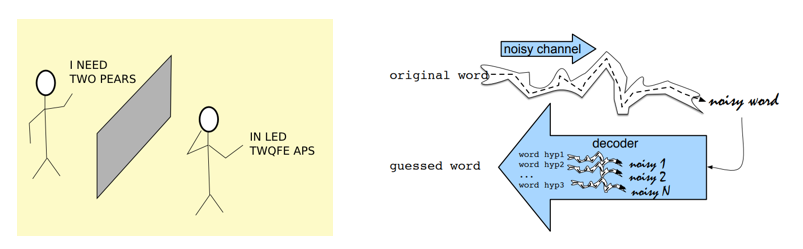

Inspired by Claude E. Shannon's seminal work on information theory ([Rudra, 2007](https://cse.buffalo.edu/faculty/atri/courses/coding-theory/lectures/lect8.pdf)), the **noisy channel model** is one of the most widely used approaches to spelling correction. The idea is to pass an input word to a channel that introduces "specks" of noise &mdash; similar to an audio-distorting wall (as suggested by the picture on the left, taken from [here](http://www.inf.ed.ac.uk/teaching/courses/inf1-cg/lectures/23/noisyChannel2.png)); in the context of spelling correction, this noise may come in the form of substitutions, insertions, deletions, or transpositions. In the figure on the right (taken from Jurafsky and Martin [2021]), the resulting noisy (misspelled) word is termed `noisy word`.

Ergo, the objective is to build a model (or an approximate replica) of this noisy channel. To decode the intended spelling of `noisy word`, different candidate corrections are passed to this model. In the illustration, the $i$<sup>th</sup> candidate correction is `word hyp i`, and the result of passing it to the noisy channel model is `noisy i`. The different instances of `noisy i` are then ranked according to their similarity to `noisy word`, and the `word hyp i` that corresponds to the most similar one is tagged as the most probable spelling correction.

This preliminary description highlights the two most important components of the noisy channel model: the candidate words and the model of the noisy channel; the former is generated via the **language model** while the latter is also referred to as the **channel model** or the **error model**. As pointed out by Jurafsky and Martin (2021), this intuition is formalized as a Bayesian inference. 

However, one of the challenges while reflecting on this project is that this connection may come off as a "rabbit pulled out of the hat" without some prior knowledge of probability theory. To supplement the discussion found in their book and strengthen the mathematics behind it, it may be helpful to note the antecedents and the consequent in a Bayesian inference:
- The first antecedent is a **prior probability**, denoted by $P(c)$. This corresponds to the language model. An egregiously simplistic, non-Bayesian model would just recommend corrections based on the most probable words suggested by the language model. <br><br>
- The second antecedent is a **likelihood function**, denoted by $P(w|c)$. This corresponds to the error model. In mathematical terms, this is related to the evidence used to update the prior probability, which is the heart of Bayesian inference. It translates to the probability that a given (incorrect) sequence of characters would be typed when the user intended a different sequence of characters. <br><br>
- The consequent is the **posterior probability**, denoted by $P(c|w)$. This corresponds to the output of the noisy channel model: the likelihood that the user intended a (correct) sequence of characters when they typed a misspelling instead.

Let $W$ be the set of words in the corpus. In light of Bayes' theorem, the most probable correction $\hat{w}$ is given by 

$$\DeclareMathOperator*{\argmax}{argmax}
\hat{w} = \argmax_{c \in W} P(c|w) = \frac{P(c) \times P(w|c)}{P(w)}.$$

Since $P(w)$ is constant for each word and, is thus, immaterial to the relative probabilities, the formula above can be simplified to

$$\DeclareMathOperator*{\argmax}{argmax}
\hat{w} = \argmax_{c \in W} P(c|w) = P(c) \times P(w|c).$$

### Implementation

The implementation in this notebook follows the noisy channel model discussed in class. In particular, a unigram language model is employed, and the minimum edit distance is limited to 1. The measure used is Damerau-Levenshtein edit distance, where a uniform unit cost is assigned to all four operations (insertion, deletion, substitution, and transposition). 

Aside from this default model, several variations of it are also built as part of the experimentation:
- To investigate the effect of case folding, two spelling correction models are created: one where all the words are converted to lowercase and one where the case is preserved. The differences in their output will be discussed in **Section B.2**, in relation to maximizing the utility of the error model. <br><br>
- To investigate the effect of the minimum edit distance, a model inspired by the idea of backoff is built; if no candidate correction is within a minimum edit distance of $n$, it proceeds to incrementing the distance window to $n+1$ and so on, until a candidate correction is found. This is further analyzed in **Section C**, side by side the evaluation of the model's performance. 

Let $W$ be the set of words in the corpus and the input word be $x$. The flow of the algorithm is as follows:

1. If $x$ appears in $W$, it is recognized as a valid spelling. Therefore, spelling correction is not performed.
2. If $x$ does not appear in $W$, it is recognized as a misspelling.
   1. Iterate through each word $w$ in $W$. If the Damerau-Levenshtein distance between $w$ and $x$ is equal to 1, then it is added to the set $C$, which represents the candidate corrections.
   2. For each word $c$ in set $C$:
       1. Compute the probability related to the prior knowledge of a given candidate word in a unigram language model, i.e., $P(c)$. This is done by counting the occurrences of $c$ in the corpus and dividing it by the number of tokens in the corpus. 
       2. Compute the probability of the edit in relation to the error model, that is, the likelihood that a given (incorrect) sequence of characters would be typed when the user intended a different sequence of characters. This corresponds to $P(w|c)$. This is done by getting the frequency of the correction in Norvig's list of spelling corrections and dividing it by the number of times the correct sequence occurs in the corpus.
       3. Compute the final (posterior) likelihood of the candidate correction by multiplying the probabilities obtained from the two previous steps.
   3. The element $c$ with the highest final likelihood is taken as the most likely correction.

Some optimizations done include precomputation of the probabilities related to the prior knowledge of a given candidate word in a unigram language model. The rationale is to avoid the expensive $O(n)$ recomputation (where $n$ is the number of tokens) if the spelling correction program is used repeatedly (e.g., during testing). Additional optimizations done to optimize the computation of the edit distance and backtracing are detailed in the code portion of this notebook.

## B. Corpus and Confusion Matrix

At the heart of the language and error models are the corpus and the confusion matrix. However, it is difficult to give a conclusive definition of an "ideal" corpus and confusion matrix. While spelling correction is typically understood as a general or domain-agnostic task, it can also be fine-tuned to more specific classes of documents, such as medical reports ([Mykowiecka & Marciniak, 2006](https://link.springer.com/chapter/10.1007/3-540-33521-8_56)) or clinical records ([Lai, Topaz, Goss & Zhou, 2015](https://www.sciencedirect.com/science/article/pii/S1532046415000751)). In this case, it would be ideal to consult corpora and matrices that belong to the same domain. 

It is, therefore, necessary to first establish that this notebook assumes a **general or domain-agnostic** stance to the spelling correction task. Moreover, since the input is restricted to single-words, it is reasonable to restrict the scope to **non-word spelling errors**. It is from this perspective that this section evaluates the suitability of the corpus and the confuson matrix, and suggests recommendations on how they can be modified to make the model more accommodating. 

### 1. Corpus-Related Concerns

In evaluating the suitability of the corpus, it may be helpful to lay out some guidelines:
- **It should contain high-quality data**. The corpus should not be contaminated with misspellings or words that do not belong to the language. 
- **It should be as comprehensive as possible**. If the corpus is limited, then several correctly spelled words will be erroneously tagged as misspellings.
- **It should reflect the current usage of the language**. For instance, the word `tythe` is an obsolete spelling of `tithe`. While `tythe` is technically not a misspelling, it is most likely not the intended spelling of a present-day typist; even Microsoft Word's spell checker tags it as a misspelling. Therefore, the corpus should ideally not contain obsolete spellings and the like.

The corpus used for building the language model was a subset of the documents elecronically archived in Project Gutenberg. The script below prints the titles (file IDs) of these documents. 

In [16]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

All 18 documents are all canonical literary texts and are stored in a reputable electronic archive, which implies that they are high-quality data that have undergone multiple rounds of proofreading. It is expected that they do not contain instances of unintentional misspellings or typographical errors. While there is a mixture of prose (e.g., Jane Austen's *Emma*) and poetry (e.g., John Milton's *Paradise Lost*), all of them belong to the genre of fiction, and there may be words common in nonfiction texts that are not captured. Nevertheless, the presence of 42,339 unique tokens (cf. the output of the script below) vis-à-vis the 171,146 commonly used words in the English language ([Sagar-Fenton & McNeill, 2018](https://www.bbc.com/news/world-44569277)) may be taken as a rough and nonrigorous attestation that it captures almost a quarter of the commonly used words in the language.

In [17]:
len(all_words_lowercase)

42339

The paramount issue lines with respect to the third guideline. Among the 18 words, only five were published in the last century: Thornton W. Burgess' *The Adventures of Buster Bear* (1920), Sara Cone Bryant's *Stories to Tell Children* (1918), and G.K. Chesterton's *The Ball and the Cross* (1909), *The Man Who Was Thursday* (1908), and *The Wisdom of Father Brown* (1914). None were published in the 21<sup>st</sup> century. In order to gain a more concrete picture of the effect of this observation, the script below outputs the words that are present in the Project Gutenberg corpus but are not present in three NLTK corpora containing documents published in the 20<sup>th</sup> and 21<sup>st</sup> centuries: Brown, Reuters, and Web and Chat Text Corpora.

In [18]:
nltk.download('brown')
nltk.download('reuters')
nltk.download('webtext')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [19]:
from nltk.corpus import brown
from nltk.corpus import reuters
from nltk.corpus import webtext

all_words_brown_reuters_webtext = Counter()
for filename in nltk.corpus.brown.fileids():
    words = [word.lower() for word in nltk.corpus.brown.words(filename)]
    all_words_brown_reuters_webtext.update(words)
    
for filename in nltk.corpus.reuters.fileids():
    words = [word.lower() for word in nltk.corpus.reuters.words(filename)]
    all_words_brown_reuters_webtext.update(words)
    
for filename in nltk.corpus.webtext.fileids():
    words = [word.lower() for word in nltk.corpus.webtext.words(filename)]
    all_words_brown_reuters_webtext.update(words)
    
ss = set(all_words_lowercase) - set(all_words_brown_reuters_webtext)
for word in ss:
    print(word, end='\t')

ashdothpisgah	hara	waxwork	fuddled	olympus	kirjathbaal	rashnesse	easinesse	tattooings	duffey	curdled	masted	flitted	controverted	unstranded	idolaters	?'"	knockers	_secret_	slippeth	blisteringly	satanic	inconstant	conciliating	anchises	annuall	blockes	jaffa	unmirthful	skalds	soliloquizing	watry	comforteth	dishonour	vnschool	mail_	thyestean	loveth	iconium	strucke	armoury	supposition	madnesse	commotions	talitha	schoole	ispah	steelkilt	barke	plethoric	mischance	asterisk	proboscis	intrenchant	harme	iudgements	reposeful	ebullition	contemns	stal	journeyings	unstreaked	suspition	cuthah	aladdin	dentistical	mightie	madmannah	hipp	carnally	rakkon	baronetage	satyrs	fobbing	almane	seconded	moue	gallina	unmanly	harum	lackaday	rabba	lifelessly	doxology	ashdodites	curre	mahlites	headstrong	nominalism	zealanders	testator	00021053	hazarmaveth	jamin	alluringly	phaseah	hums	behest	invokingly	artificiall	meete	emanative	condiment	transgressing	pharah	skald	gier	foretasted	treasurest	chagrined	kishon	encasi

uncontaminated	greatnesse	pheasantry	greeued	pismire	sabians	whaleboning	boyes	ethanim	titinius	cuffes	awkwardnesses	raamah	noblenesse	marketless	pastiles	scurf	monstrousest	pluto	zilthai	sawcie	spattering	forfeiture	intimation	numismatic	indifferently	parcelling	ghauts	flume	remiss	trefoil	encrease	forceps	skreenes	oppos	requisitions	luff	mischeefe	vrge	putridity	elixir	brigandine	roarings	halak	neriah	asmodeus	lyst	gonzago	jobab	duelled	magyar	zuyder	landward	sychem	chooseth	bequeath	undistinguishing	windes	blameable	forethrown	tattling	haniel	loiter	_introduction_	memorandums	edar	zobah	waiteth	gaffs	spluttering	cadmus	twas	potentates	acte	lactantem	72d	sitka	toper	rezon	eshcol	emprises	prenominate	discorrupt	puh	colney	enigmas	jeshohaiah	mazzaroth	maintainest	whiter	summes	coniectures	joshbekashah	weepeth	upheaving	fibred	neverthless	soused	skysail	pantheists	compoundeth	obeyedst	misse	cutpurse	crikey	caecias	spight	gouern	armfuls	reflectively	profaning	wedging	bradshaw	shearer	typ

	diner	norwey	unendeared	amputations	serle	gederite	alchymie	bethcar	lineaments	lunched	fugue	roasteth	chastise	jerijah	incumbrances	zebah	zophiel	witchery	astoreth	butteries	eruptions	champain	shewest	trebly	hazarshual	rhegium	implead	wassell	ithiel	gaue	wip	xxi	enjoyedst	monthes	unbarred	balles	_you_	elam	shuppim	levites	specked	loosed	couchings	entappuah	'"--	cluny	brigger	repeateth	vnmatch	bachrites	scotcher	smeerenberg	marauder	apish	circumcise	defyingly	allemaine	beauer	snorer	wriggling	shamefull	ibneiah	barsabas	farwell	spurn	mistooke	sebond	marrowlesse	gleams	unpitied	rais	placard	tossings	beguiles	stammerers	sated	ditchers	fearefull	arad	orizons	unvitiated	almansor	bareheaded	lodg	confound	_home_	hazeroth	azrikam	tittle	xxvii	pliny	bealoth	daffodil	indite	mahazioth	falconroy	martyrdoms	hege	prophesy	quaff	drugges	subiect	checkmated	superinduced	aloofe	jehu	foameth	happenest	unwell	joes	_lady_	zererath	kindreds	demy	voicelessly	persue	hashupha	nebaioth	shama	phallus	blanketing	

reaps	miletum	correcteth	mastless	sandersons	tarsus	benefactors	compasse	mittened	lookingglasses	uttereth	og	malefactor	sycophant	breastplates	unfearing	abhominably	surmisings	fruitfull	contumacy	woodbine	spearmen	nineve	esteemeth	skrimmage	tranque	buyest	interlocks	undrawn	exhorters	lents	chanson	savesoul	osities	reme	dissolv	adulteress	surroundest	salathiel	milke	washpot	mither	unsounded	elienai	jahzeel	stander	louingly	undiscerning	necromancer	adaies	conjoint	laburnum	weare	searcheth	rephaim	noone	winterwork	bethharan	kingdomes	inoffensive	surest	unhooped	upstood	jediael	dil	throbb	thumbe	unrestrained	gaddiel	haberdasher	ganders	inestimable	obediently	windpipe	hachaliah	caricatures	effusion	sauiours	thrusteth	birmah	monotonously	tributary	shears	transubstantiate	alleghanian	lapp	desirest	gentlewoman	imployment	groaneth	eulogy	endamage	sunne	hyr	incorporeal	possessest	ahoah	confesseth	sayd	rambled	heeva	bellied	abiure	emblazonry	outherod	foine	apologizes	ithrites	conundrums	genuinene

	artlessness	intercessions	zigzags	limbered	unbare	algum	torments	hyacinth	cleanliest	_recollecting_	conical	strato	samoed	hellespont	idolater	disburthening	elbruz	supernumerary	erblown	livest	sanguinely	reproachest	howle	lemnos	sweare	larning	goshen	chalcol	pell	boastest	rapturous	bestride	hallooing	bisogna	cals	inductive	laziness	deafening	tookest	indispensableness	inferiors	smild	methodic	palsies	cumbrous	fractur	mesopotamians	refiningly	herdsman	windlass	remoued	harbinge	achings	asherites	multipliedst	hackluyt	hadashah	facetiousness	scillies	buttes	narrations	petsora	hyssop	louring	rossmore	kinswoman	unmoveable	flatterers	odder	portall	pacifying	platformed	belike	commodious	serveth	unawed	morbific	hosannas	poesie	crisped	cyclic	extricated	cogency	spermaceti	uncovereth	crapulous	christs	etherial	hilles	dresse	chid	outlast	bestuck	wildered	antipathies	allon	tearless	hophni	bloude	reverential	anahuacs	confesse	vpper	dum	unnumber	unpossessed	preachest	horam	pitchpoled	helpfull	peninsul

	tiar	shaharaim	sanctitude	alexandrian	unstirring	fawns	horsey	fornicator	unpierceable	hamuel	quaintness	travaileth	heardest	spreadings	thinnest	shobi	peerelesse	repossessing	teff	jonadab	gutenberg	boue	suitableness	uphaz	sunniest	cheapside	sooty	unobnoxious	tempestuous	slothfulness	outswelling	ziphion	limiteth	splendours	hamo	whizzings	paged	adelphi	upbraideth	agonised	hispahan	spendest	vnkindest	farwel	helpeth	stereotyping	groanings	undoubting	chantant	joying	wisedom	stoutish	gigs	poratha	cumber	1842	seethed	omnisciently	bespattering	northwards	bogs	dreading	prismatic	hent	shigionoth	admeasurement	miphkad	forgers	droused	venial	clogges	lyar	sombrero	cognisance	mysterie	togarmah	fleshhook	comfortless	archippus	subordinately	pitteous	lachish	messa	ismachiah	dribbles	changeling	jabbok	ruination	dribs	rebounds	bosporus	hyrcanian	pirouetting	metaphysically	ossa	exulting	preserver	abelshittim	whiffe	tyrannicide	gilead	pampas	gibea	capitall	abilitie	solicitously	jecamiah	holier	reuiuing	sco

bewaileth	rubarb	galvanized	haile	daggers	unfledg	highth	ellasar	bllcr11	abarim	throated	thinkst	accusers	hunchbacks	azel	beauchamp	passports	tumults	quayle	mustereth	interude	arbours	cawdron	alleviations	promontories	insipidity	pransings	muffle	faulcon	greefe	jabeshgilead	pobox	caphtor	plateaus	rechah	deliciousness	turnes	lepers	merchantmen	underfed	bllcr10a	cornets	uthai	golgotha	pransing	extolled	boastful	credent	erelong	halhul	valdarno	ulysses	chiefe	confin	tarriest	merom	edom	humblest	caska	;--"	fardles	zephathah	puzels	perezuzzah	_bath_	aske	bestirring	lamenting	emerg	oeuvre	frobisher	ashima	cockades	lemaître	shamefully	centaurs	behoved	pirathon	jub	inhospitably	stord	vinculomania	affayre	wherfore	unlover	aboriginally	marvellously	sauvera	hoard	errest	angers	unannounc	godmother	knightleys	zaccai	sare	bobs	fowlers	raking	cursorily	lud	hermonites	telled	getteth	ilium	chaunted	yawed	lethee	humiliations	pompeyes	disconcerted	angerly	cudgel	lusteth	plaything	surety	heber	multiplieth	c

needeth	sorroweth	pamphylia	pacified	changeful	fayl	bloodthirsty	screwing	garrisons	homelike	siaha	resuscitation	subsists	accoucheur	whew	gritted	extolling	sinells	gamesom	melatiah	pervade	ravenswood	humorousness	pinny	receiveth	necturous	fixion	christenings	godby	moou	roarers	scolds	arnhold	ezar	shouldest	targe	pottowottamie	zebudah	complie	sepharad	votin	unlimber	laodicea	makheloth	scheld	girdest	prepossessed	regimental	curbstone	compassed	partakest	gosling	turfed	limbes	biteth	causeway	shallowest	adde	drear	phuvah	runneth	lystra	plentifull	esarhaddon	aphekah	eutychus	droppes	jerushah	uncreated	jashubites	lepidus	shelomith	honourable	abstruse	opined	compulsatiue	ramath	ennactors	saturate	princely	unmerciful	balaene	hazaiah	pallidness	brompton	fulham	pruriently	timotheus	clasp	havock	tirathites	monarkes	zuzims	milliners	swearers	swoope	masterdome	chambering	lawes	l150	disagreeableness	samarchand	hashabniah	shearjashub	unintelligent	orientals	portioning	fustian	hamutal	slue	afterglow	w

debel	matest	abbeyland	kinsman	curtsying	nephthalim	forenoon	clovenfooted	eton	aggrandise	thebez	embellishments	tattersall	superiour	linnen	abbreviate	seedtime	shimronites	tride	foure	wrestlers	slay	humourist	pedlars	jotbath	inhaled	harmonick	soapstone	soop	treasuring	barrister	hazaraddar	foolscap	unclosing	enrimmon	_shall_	telmelah	nebajoth	hobbling	cholo	adiel	vnsure	omnes	emulous	oboth	rapturously	baleine	milkmen	nomads	indissoluble	archness	shimeathites	bethshemesh	lascars	jetur	oftest	exordium	wringed	purlieu	chast	answereth	pacifieth	semiweekly	binnacle	aereal	!--`	sealeth	poisoners	spotter	hanameel	clayme	,"--"	pommery	shopfronts	bonneterre	hindoos	ithnan	airley	shrewdness	whats	jael	proch	lugubrious	coz	bruit	athaiah	equiuocation	mungrels	sences	slumbereth	vouchsafe	rejoiceth	mislead	hoarded	pated	senir	unrefuted	sprouts	ninepins	tyber	behaveth	crieth	valetudinarian	zacher	ropeyarn	stooles	idealists	ishbak	entreatments	eleusis	churchman	frowardness	harbonah	riveted	wellbred	fla

owle	flaked	leprous	osity	dizahab	unwarped	wheelerite	whoredoms	zare	ladiship	diggedst	unlaunch	shticks	syriamaachah	broils	laving	calledst	squadroned	appointeth	mirrour	coppice	ragge	defies	holdeth	ciphering	milliner	iouiall	islet	osceola	toucheth	vultur	lamentable	dy	fauors	nimrim	disguising	fount	sapience	abbana	vitalizing	chattahooche	guidon	reflux	bethmeon	."*	discovereth	cinque	blowes	subsisted	maroth	slumberings	masonries	gipsies	adiew	worryings	barbars	mummeries	decius	mercies	ofttimes	vapoured	rentest	otherways	deshabille	rencontre	shupham	widdow	dumfoundered	symes	mishma	hearthrug	elishua	basketed	flatting	polemen	encrustations	susanchites	denominating	sayest	hashum	rectory	hugger	condolence	nibbled	vpmost	boudge	mithcah	waites	ignominious	patroling	festivity	cosins	henoch	asarelah	concernings	zebina	scottato	brainless	hillocks	pacifics	abijah	goblets	howsoeuer	windmills	fulfils	dreadfull	overcharge	outstript	swinish	vertumnus	defensively	8oo	jaakobah	tahtimhodshi	crape	dispu

undetached	bouverie	messe	jehudi	monsoons	magnetick	shiphrah	viands	unworthily	choake	timnathserah	castors	ides	sojourneth	leuwenhoeck	leth	urchins	shrewder	morrice	horrour	adaiah	vbique	hatefull	reuolution	nahalal	jeuz	tragick	shovelled	nois	dingily	penetrable	represt	sacredly	exasperations	whaleship	deepely	gamaliel	unfaltering	simri	moonstruck	affrighted	blacksmithing	somerses	gastly	maidservant	tartak	*:	jaminites	clamouring	repartees	naarai	peevishly	intrench	evildoer	_tap	martiall	musters	adramelech	perizzite	express_	sibbecai	matred	sardonically	fetcheth	_broke_	tapor	zeuglodon	cobl	vertue	calendula	unresponse	bowings	superannuated	slewing	breasting	priams	lifter	bowd	sweno	subtil	archeresses	undefiled	ecliptick	shedder	complaire	twentie	tuns	magormissabib	sendeth	valved	blains	sackclothes	blossomes	modernist	plashing	abinadab	_invite_	omens	hori	entanglements	brawniness	angler	debased	shaul	accompt	artire	indescribably	odoriferous	grosser	fatall	franchis	cray	deferreth	authoriz

	toting	strows	hore	inferiorities	personableness	bithron	lieve	succourless	mahlah	hart_	harpstring	repinings	poi	ammon	amon	hyperborean	embellishment	inartistic	proselyte	jehaleleel	egotistic	inmost	minished	secrecie	maaz	fogge	backwardly	stumblingly	geliloth	hushai	constancie	redtail	bladed	middlemost	drinketh	stilled	medeba	plaints	handcuff	l10	nonchalantly	biffin	puls	dispenses	overflown	buzzer	spiralizes	boozy	emblazoned	endor	labourers	incompetency	achbor	landlessness	anacharsis	pirathonite	resteth	gershon	barked	blanco	habiliments	avenger	weazell	splint	hatest	dorsetshire	goest	schouten	cleaves	zodiack	goney	dissentient	harpooner	luccio	lookouts	inions	cornice	loweth	shimshai	yis	flaunt	uproarious	blights	soonest	sightlesse	sheaths	reasonings	andromeda	zibeon	smyling	stubborne	dispels	enlargeth	invariability	billeted	unhorse	marishes	pulverize	buzzard	gat	platane	15o	regaling	ishuai	airth	fossils	battledore	sanctities	luz	sleepiest	tithe	owt	twer	vnhouzzled	gazites	solicites	zare

	fredda	lashless	harpooneers	camomile	diblath	formost	wharfe	rore	whistler	reares	ploughman	plaited	unlarned	ludicrously	facings	quakerish	inforced	sikoke	mown	sequential	provender	syme	teak	splendour	electrotyping	trudging	ermatched	torsoes	exployt	pellicera	muscularly	refraineth	manahath	raamiah	wrinkling	mahershalalhashbaz	amativeness	atarothadar	gerar	invitingly	unargued	tenderest	promenaders	arimathaea	hish	subalterns	lecherous	sunn	ephraimites	broakers	overspreading	casement	steersman	

Although there are some words that still appear in modern written texts and spoken conversation (e.g., *outwitted*, *alms*, and *promptness*), there are some spellings that are now considered obsolete or nonstandard. With the now-standard spellings in parentheses, examples include *dissembleth* (*dissembles*) and other words that end in the archaic verb conjugation suffixes, *shrinked* (*shrank*), *tythe* (*tithe*), *centinell* (*sentinel*), and *poysoning* (*poisoning*). As a result, these obsolete or nonstandard spellings will be deemed valid by the spelling correction model. 

NLTK combines the Punkt sentence tokenizer and Treebank tokenizer to perform word-level tokenization. However, running the script below shows that hyphens are present only in punctuation strings. This is indicative of a peculiar behavior (that is not observed when using NLTK's word-level tokenizer): hyphenated words are tokenized into their constituent words. This may be traced to how `nltk.corpus.gutenberg.words` actually defines a word.

In [20]:
for word in all_words:
    if '-' in word:
        print(word, end = '\t')

-	--	.--	?--	!--	;--	--"	,--	:--	"--	,"--	--(	)--	.--"	;--"	--`	----------,	!"--	--------.'	."--	.'--	!--(	'--	!)--	!'--	?"--"	?"--	.'--`	?)--	;"--	:"--	,--"	:--"	.--`	;'--	!--"	!--`	--.'	).--	?--"	);--	--.	:'--	--."	--,	--:	----	?--(	,)--	---	--;	--!	,--`	.--,	,"--"	---.	.--,"	-?	-?"	--'	,-	.)--	----"	--"'	'"--	)--'	):--	.--'	--]	'-	----!"	--?"	--'"	--?'	,'--	-"	*--	"--(	!.--	-----	;-	---"	;--'	?'--'	,--'	?--'	.*--	---,	:--'	:"-	;"--(	',--	!--'	;)--	

This highlights another weakness of the language model. Since the tokenization of the documents in the corpus results in the loss of hyphenated words, it automatically tags a hyphenated word input as a misspelling. Analogously, it is unable to make corrections that involve the insertion of hyphens to recover the intended word. These are illustrated in the code segments below.

In [21]:
get_spell_correction('in-law', is_lowercase=True)

Output:


,word,candidate,edit_type,edit,P(c),P(w|c),P(c) x P(w|c)


[]

In [22]:
get_spell_correction('inlaw', is_lowercase=True)

Output:


,word,candidate,edit_type,edit,P(c),P(w|c),P(c) x P(w|c)
0,inlaw,inlay,sub,w | y,0.000000,0.000006,2.166806e-12


['inlay']

Moreover, it is also possible to find words that contain punctuations and numbers (or consist solely of punctuations and numbers). To provide a rough idea of their occurrence in the corpus, the scripts below enumerate them. At the surface level, there seems to be no harm in having these words recognized as valid spellings. However, since the noisy channel model operates by considering words that are *not* in the corpus as misspellings, this means that punctuation- or number-containing words that are not found in the list below will be marked as misspellings. Given the almost-arbitrary manner of constructing punctuation- or number-containing words, there is no corpus that can satisfactorily capture them. This gives rise to the problem of overcorrection.

In [23]:
from string import punctuation

for word in word_probabilities:
    for p in punctuation:
        if p in word:
            print(word, end='\t')
            break

[	]	,	;	-	.	'	_them_	--	.--	:	?--	(	)	"	!--	!"	;--	?"	?	."	!	_We_	`	.'	_one_	,"	_you_	--"	_will_	,'"	,'	_that_	,--	_She_	_little_	_very_	_half_	_small_	_she_	_two_	_her_	:--	,)	_wanted_	_him_	_gentleman_	_us_	"--	_then_	,"--	_your_	_here_	;'	?'"	--(	)--	_at_	_present_	.--"	;--"	_purport_	_doubts_	_You_	;"	.'"	_was_	_letting_	_particular_	_lady_	_Courtship_	--`	----------,	_court_	_ship_	_courtship_	!"--	--------.'	_happily_	_well_	_appropriation_	?'	_I_	),	."--	_now_	_not_	.'--	_he_	_nearer_	_both_	_we_	&	_My_	_my_	_were_	).	_woman_	_man_	_when_	_promise_	_me_	!--(	_unrequited_	_sensation_	'--	_joint_	!)--	_wish_	!'--	_______	?"--"	?"--	.'--`	_boiled_	?)--	_try_	_Mrs	_	_Elton_	_What_	_who_	.,	_married_	_great_	_way_	_just_	_The_	_Rev	_Philip_	_White	Hart_	_Bath_	_He_	;"--	:"--	"'	_home_	_own_	,--"	_eighteen_	_amor_	_patriae_	_did_	_his_	_moment_	_compliments_	_ten_	_Now_	_say_	_thoughts_	_Mr_	_times_	_with_	_time_	:--"	!'	.--`	;'--	.,"	_would_	_all_	_party_	_has_	_Robin_	_Adair_	_invit

In [24]:
for word in word_probabilities:
    if any(char.isdigit() for char in word):
        print(word, end='\t')

1816	8th	23rd	28th	24th	7th	10	000	26th	1818	1	1760	15	1784	1800	1785	9	1787	5	1789	20	1791	16	1810	1814	2	3	4	1806	6	29th	7	8	11	12	13	14	17	18	1st	19	21	1803	22	23	24	1811	7000L	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	200	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	1780	1918	1920	_71_	1865	1909	L12	L10	bllcr10	bllcr11	bllcr10a	etext03	etext02	01	00	2002	1240	2001	4000	2000	1971	1991	1994	1000	1997	1500	1998	1999	2500	3000	6000	9000	2003	10000	2004	1739	38655	4109	501	622154	02	1914	379	1908	1350	217	25th	22nd	1799	8OO	1414	15O	2nd	3rd	4th	5th	

Rather than removing these punctuation- or number-containing words from the corpus, an easier and more reliable approach would be to maintain a blacklist so that pure punctuations and numbers are not corrected; Google extends this blacklist to single characters ([Whitelaw, Hutchinson, Chung & Ellis, 2009](https://dl.acm.org/doi/10.5555/1699571.1699629)). Although unrelated to the corpus per se, another technique to mitigate overcorrection, as posited by Jurafsky and Martin (2021), is to accept the top candidate correction only if the difference between the probability of it being the correct spelling (i.e., $P(c|w)$) and the probability of the input word itself being the correct spelling (i.e., $P(w|w)$) is greater than a threshold $\theta$: $P(c|w) - P(w|w) > \theta$.

Returning to the corpus, a possible improvement would be to limit the selection to more recent documents, such as high-quality literary works, news articles, or scientific papers published in this century or in the last century. Although online sources, such as tweets, chat logs, and forum posts reflect the current usage of the language, misspellings abound in these data sources, and manually sifting through them is laborious. On the more linguistic side, the choice of the corpora, particularly with respect to the third guideline, may be tied to debates between the prescriptive and descriptive schools of thought on what determines the canonical spelling of a word &mdash; this is the subject of lively discussion even among lexicographers.

### 2. Confusion Matrix-Related Concerns

The confusion matrix for the error model was constructed from Peter Norvig's [collection of spelling mistakes](http://norvig.com/ngrams/count_1edit.txt), which, in turn, originates from misspellings in Wikipedia. In reference to the three assumptions laid out in the previous subsection, it may be helpful to assess the quality, comprehensiveness, and relevance of the data source. With its 6,504,264 articles ([Wikipedia, 2022](https://en.wikipedia.org/wiki/Wikipedia:Statistics)), Wikipedia can be considered comprehensive, and it certainly reflects the current usage of the language. However, the impact of the wiki policy (i.e., any user can contribute or edit articles) on the quality can be quite contentious. Regardless, since the final outputs are aggregate counts, the presence of a handful of incorrect spellings in Wikipedia is drowned out and, thus, does not significantly affect the quality of the resulting error model.

To further augment the error model, data related to keyboard-based edit distances may be integrated although this may be more relevant to languages where the screen output is not a verbatim mapping of the original keyboard input, as in the Chinese characters that are first typed in romanized Pinyin ([Sha, Jun, Qinghua & Wei, 2011](https://link.springer.com/chapter/10.1007/978-94-007-2105-0_5)). Another approach would be to incorporate phonetic information; to this end, GNU Aspell, the standard spell checker of the GNU operating system, employs Lawrence Philips' metaphone algorithm ([Aspell, n.d.](http://aspell.net/metaphone/)), which is an improvement over the older Soundex algorithm. 

Returning to Norvig's collection of spelling mistakes, it may be interesting to note that the rules are limited to transpositions and single-character corrections (insertions, deletions, and substitutions) &mdash; making it compatible with the Damerau-Levenshtein distance. Moreover, it is case-sensitive, as evidenced by the presence of rules like `o|O` and `i|I`. Therefore, the error correction model should be case-sensitive as well. Nevertheless, to explore the effect of case folding, separate models were built.

Case folding naturally results in varying final probabilities although the differences are generally miniscule (roughly in the order 10<sup>&ndash;2</sup>). The more important difference is with respect to the correction of named entities, as seen in the code segments below. When case folding is applied, `america` is not tagged as a misspelling. On the other hand, if the case is preserved, it is corrected to `America` &mdash; as desired. In summary, it is more preferable to preserve the case. Meanwhile, the role of named entity recognition in spelling correction is revisited in the final section **Beyond the Noisy Channel**. 

In [25]:
get_spell_correction('america', is_lowercase=True)

Output: No error


'Output: No error'

In [26]:
get_spell_correction('america', is_lowercase=False)

Output:


,word,candidate,edit_type,edit,P(c),P(w|c),P(c) x P(w|c)
0,america,America,sub,a | A,0.000039,0.000124,4.816159e-09


['America']

## C. Evaluating the Model

The previous sections have already touched on some preliminary observations related to the performance of the model. To lend some rigor to the evaluation two test sets are used. The first is the test set used in the development of GNU Aspell, which is a fairly standard test set used in evaluating spelling correction models. On the other hand, the second is a difficult test set taken from the contestants' errors in the Scripps National Spelling Bee. (In this regard, the model should not be unfairly judged by its performance in the second test set; the intention for using it is purely exploratory.)

### 1. GNU Aspell

The model is evaluated through the [test set](http://aspell.net/test/common-all/) used in the development of [GNU Aspell](http://aspell.net/), the standard spell checker of the GNU operating system. Containing 4,206 entries, this set is derived from the list of common misspellings provided by Wikipedia. It can be recalled that this spell corrector's [error model](http://norvig.com/ngrams/count_1edit.txt) is based on Wikipedia as well.

In [27]:
with open('aspell-test.txt') as f:
    test_set_1 = {}
    
    for line in f:
        # For each line in the file, separate the spelling mistake and its frequency.
        misspelled, correct = line.split("\t")
        misspelled = misspelled.strip()
        correct = correct.strip()
        
        test_set_1[misspelled] = correct

### ⚠️ WARNING! The script below takes around 12 hours to run. Uncomment to execute it.

In [28]:
"""
BATCH_SIZE = 20

error = {}
correct = 0
ctr = 0

for word in test_set_1:
    suggestions = get_spell_correction(word, is_lowercase=False, display_df=False)
    expected_output = test_set_1[word]

    if suggestions == NO_ERROR:
        error[word] = (NO_ERROR, expected_output)
        
    elif len(suggestions) == 0:
        error[word] = ('', expected_output)
    
    else:
        actual_output = suggestions[0]

        if actual_output == expected_output:
            correct += 1
        else:
            error[word] = (actual_output, expected_output)
        
    ctr += 1
    if ctr % BATCH_SIZE == 0:
        print("Test", ctr, "done!")
        print("Num. of correct suggestions:", correct)
      
print("Accuracy:", correct / len(test_set_1))

with open('errors-aspell.pkl', 'wb') as f:
    pickle.dump(error, f)
"""

with open('errors-aspell.pkl', 'rb') as f:
    errors_aspell = pickle.load(f)

### The accuracy of the spelling correction model against the Aspell test set is 58.08%.

In [29]:
1 - len(errors_aspell) / len(test_set_1)

0.58078273958856

### Error Analysis

The script below presents a quantitative analysis of the errors.

In [30]:
ctr1 = 0
for entry in errors_aspell:
    if errors_aspell[entry][0] == '' and errors_aspell[entry][1] not in all_words:
        ctr1 += 1
        
ctr3 = 0
for entry in errors_aspell:
    if errors_aspell[entry][0] == '' and errors_aspell[entry][1] in all_words:
        ctr3 += 1

ctr2 = 0
for entry in errors_aspell:
    if errors_aspell[entry][0] != '':
        ctr2 += 1

        
print("Intended word is not in corpus:\t\t\t\t", str(ctr1 / len(errors_aspell) * 100) + "%")
print("Intended word is of edit distance above 1:\t\t", str(ctr3 / len(errors_aspell) * 100) + "%")
print("Top candidate correction is not the intended spelling:\t", str(ctr2 / len(errors_aspell) * 100) + "%")

Intended word is not in corpus:				 59.54518252543387%
Intended word is of edit distance above 1:		 19.449431478156793%
Top candidate correction is not the intended spelling:	 21.005385996409338%


The script below prints the instances wherein the **intended word is not in the language model's corpus in the first place (59.55%)**. The resolution to this class of errors would be to make the corpus more comprehensive. For example, correcting the misspelling *telelevision* was impossible since televisions were only invented in 1927, and the most recent literary work in the Project Gutenberg corpus was published in 1920.

In [31]:
for entry in errors_aspell:
    if errors_aspell[entry][0] == '' and errors_aspell[entry][1] not in all_words:
       print(entry, errors_aspell[entry])

aberation ('', 'aberration')
abondons ('', 'abandons')
aborigene ('', 'aborigine')
abortificant ('', 'abortifacient')
abreviated ('', 'abbreviated')
abundacies ('', 'abundances')
abundancies ('', 'abundances')
acadmic ('', 'academic')
accademic ('', 'academic')
accelleration ('', 'acceleration')
acclimitization ('', 'acclimatization')
accomadates ('', 'accommodates')
accomodates ('', 'accommodates')
accordeon ('', 'accordion')
accordian ('', 'accordion')
accoustic ('', 'acoustic')
acedemic ('', 'academic')
acheives ('', 'achieves')
additinally ('', 'additionally')
addoptive ('', 'adoptive')
addresable ('', 'addressable')
admininistrative ('', 'administrative')
adminstrate ('', 'administrate')
adminstrative ('', 'administrative')
adminstrator ('', 'administrator')
admissability ('', 'admissibility')
admitedly ('', 'admittedly')
adolecent ('', 'adolescent')
adquires ('', 'acquires')
adresable ('', 'addressable')
adressable ('', 'addressable')
aeriels ('', 'aerials')
afficianados ('', 'af

Guilia ('', 'Giulia')
Guilio ('', 'Giulio')
Guiseppe ('', 'Giuseppe')
gunanine ('', 'guanine')
habaeus ('', 'habeas')
habeus ('', 'habeas')
Habsbourg ('', 'Habsburg')
haemorrage ('', 'haemorrhage')
Hallowean ('', 'Halloween')
harased ('', 'harassed')
harasment ('', 'harassment')
harasments ('', 'harassments')
harassement ('', 'harassment')
harrased ('', 'harassed')
harrasment ('', 'harassment')
harrasments ('', 'harassments')
harrassed ('', 'harassed')
harrassment ('', 'harassment')
harrassments ('', 'harassments')
headquater ('', 'headquarter')
headquarer ('', 'headquarter')
headquatered ('', 'headquartered')
healthercare ('', 'healthcare')
heirarchy ('', 'hierarchy')
hemmorhage ('', 'hemorrhage')
hertzs ('', 'hertz')
hierachical ('', 'hierarchical')
hierachy ('', 'hierarchy')
hierarcical ('', 'hierarchical')
hierarcy ('', 'hierarchy')
hieroglph ('', 'hieroglyph')
hieroglphs ('', 'hieroglyphs')
histocompatability ('', 'histocompatibility')
homogeneize ('', 'homogenize')
homogeneized (

triology ('', 'trilogy')
troling ('', 'trolling')
trustworthyness ('', 'trustworthiness')
tyranies ('', 'tyrannies')
tyrranies ('', 'tyrannies')
Ukranian ('', 'Ukrainian')
unathorised ('', 'unauthorised')
unavailible ('', 'unavailable')
unballance ('', 'unbalance')
unbeleivable ('', 'unbelievable')
unchallengable ('', 'unchallengeable')
uncompetive ('', 'uncompetitive')
uncontitutional ('', 'unconstitutional')
undecideable ('', 'undecidable')
undetecable ('', 'undetectable')
unequalities ('', 'inequalities')
unforgiveable ('', 'unforgivable')
unilateraly ('', 'unilaterally')
unilatreal ('', 'unilateral')
unilatreally ('', 'unilaterally')
UnitesStates ('', 'UnitedStates')
unmanouverable ('', 'unmanoeuvrable')
unoffical ('', 'unofficial')
unoperational ('', 'nonoperational')
unsubstanciated ('', 'unsubstantiated')
unsuprised ('', 'unsurprised')
unsuprising ('', 'unsurprising')
unsuprisingly ('', 'unsurprisingly')
unsuprized ('', 'unsurprised')
unsuprizing ('', 'unsurprising')
unsuprizing

The script below prints the instances wherein the **intended word is in the corpus but it is not within a minimum edit distance of 1 (19.45%)**. Therefore, the model had a difficult time correcting errors that involved multiple pairs of double letters, like *comision* (supposedly *commission*). The extent to which the window for the minimum edit distance can be extended can be determined through the use of a development or validation set, but a good rule of thumb mentioned in NLP1000 comes from the empirical observation that around 80% of the errors are within an edit distance of 1 and almost all errors are within an edit distance of 2. 

In [32]:
for entry in errors_aspell:
    if errors_aspell[entry][0] == '' and errors_aspell[entry][1] in all_words:
       print(entry, errors_aspell[entry])

absorbsion ('', 'absorption')
accomadate ('', 'accommodate')
accomadated ('', 'accommodated')
accomadating ('', 'accommodating')
accomadation ('', 'accommodation')
accomadations ('', 'accommodations')
accomdate ('', 'accommodate')
acheivment ('', 'achievement')
acheivments ('', 'achievements')
acquiantence ('', 'acquaintance')
acquiantences ('', 'acquaintances')
acustommed ('', 'accustomed')
adresing ('', 'addressing')
ahev ('', 'have')
alegience ('', 'allegiance')
allegence ('', 'allegiance')
altho ('', 'although')
apenines ('', 'Apennines')
appenines ('', 'Apennines')
appropropiate ('', 'appropriate')
approproximate ('', 'approximate')
aquiantance ('', 'acquaintance')
artical ('', 'article')
assasined ('', 'assassinated')
assertation ('', 'assertion')
assosication ('', 'assassination')
asssassans ('', 'assassins')
attaindre ('', 'attained')
austrailia ('', 'Australia')
austrailian ('', 'Australian')
authorative ('', 'authoritative')
authoritive ('', 'authoritative')
automaticly ('', 

The script below prints the instances wherein the **the top candidate correction is not the intended spelling (21.01%)**. This is rather nuanced to resolve. Aside from expanding the corpora to better model the language and the channel, it is also possible to explore the introduction of weights to give more importance on either the language model or the channel model. Another possible approach would be to consider context in creating the models. These strategies are more formally discussed in the final section **Beyond the Noisy Channel**.

### 2. Scripps National Spelling Bee

This test set consists of the words that participants of the Scripps Spelling Bee, a longstanding quiz bee in the United States, misspelled two or more times (with the exception of the entries from the 2010 iteration, as errors were found in its results data). The data is sourced from this [website](https://qz.com/1292564/national-spelling-bee-2018-the-most-commonly-misspelled-words-at-the-national-spelling-bee/). 

In [33]:
with open('spell-bee-test.txt') as f:
    test_set_2 = {}
    
    for line in f:
        # For each line in the file, separate the spelling mistake and its frequency.
        correct, misspelled = line.split("\t")
        misspelled = misspelled.strip()
        correct = correct.strip()
        
        if correct == 'â€“':
            correct = prev
            
        prev = correct
                        
        test_set_2[misspelled] = correct

### ⚠️ WARNING! The script below takes around 2.5 hours to run. Uncomment to execute it.

In [34]:
"""
error = {}
correct = 0
ctr = 0

for word in test_set_2:
    suggestions = get_spell_correction(word, is_lowercase=False, display_df=False)
    expected_output = test_set_2[word]

    if suggestions == NO_ERROR:
        error[word] = (NO_ERROR, expected_output)
        
    elif len(suggestions) == 0:
        error[word] = ('', expected_output)
    
    else:
        actual_output = suggestions[0]

        if actual_output == expected_output:
            correct += 1
        else:
            error[word] = (actual_output, expected_output)
        
    ctr += 1
    if ctr % BATCH_SIZE == 0:
        print("Test", ctr, "done!")
        print("Num. of correct suggestions:", correct)
      
print("Accuracy:", correct / len(test_set_2))

with open('errors-scripps.pkl', 'wb') as f:
    pickle.dump(error, f)
"""

with open('errors-scripps.pkl', 'rb') as f:
    errors_scripps = pickle.load(f)

### The accuracy of the spelling correction model against the Scripps National Spelling Bee test set is 2.96%. 

To reiterate, however, this is an inherently difficult test set, and this evaluation is purely exploratory (i.e., out of curiosity).

In [35]:
1 - len(errors_scripps) / len(test_set_2)

0.029649595687331498

In [36]:
ctr1 = 0
for entry in errors_scripps:
    if errors_scripps[entry][0] == '' and errors_scripps[entry][1] not in all_words:
        ctr1 += 1
        
ctr3 = 0
for entry in errors_scripps:
    if errors_scripps[entry][0] == '' and errors_scripps[entry][1] in all_words:
        ctr3 += 1

ctr2 = 0
for entry in errors_scripps:
    if errors_scripps[entry][0] != '':
        ctr2 += 1

        
print("Intended word is not in corpus:\t\t\t\t", str(ctr1 / len(errors_scripps) * 100) + "%")
print("Intended word is of edit distance above 1:\t\t", str(ctr3 / len(errors_scripps) * 100) + "%")
print("Top candidate correction is not the intended spelling:\t", str(ctr2 / len(errors_scripps) * 100) + "%")

Intended word is not in corpus:				 88.75%
Intended word is of edit distance above 1:		 3.3333333333333335%
Top candidate correction is not the intended spelling:	 7.916666666666666%


As expected, an overwhelming majority of the intended words are not in the corpus. This can be attributed to the fact that words given in competitions of the same calibre as the Scripps National Spelling Bee are deliberately selected for their rarity and orthographic difficulty.

### Employing "Backoff"

One idea that we thought to improve the model of the performance is inspired by the idea of backoff in $n$-gram language models. In this case, however, backoff is done as follows: if no candidate correction is within a minimum edit distance of $n$, it proceeds to incrementing the distance window to $n+1$ and so on, until a candidate correction is found. 

Note that, since the error model is limited to transpositions and single-character edits, there is no particular order to the sorting of the candidate corrections when the edit distance is longer than 1.

In [37]:
def spell_correction_backoff(word):
    min_edit_distance = 1
    spell_correct = get_spell_correction(word, is_lowercase=False, display_df=False)
    print("Minimum Edit Distance of", min_edit_distance)
    print(spell_correct, "\n")

    if spell_correct == "Output: No error":
        return
    
    while len(spell_correct) == 0:
        min_edit_distance += 1
        spell_correct = get_spell_correction(word, is_lowercase=False, min_edit_distance=min_edit_distance, display_df=False)
        print("Minimum Edit Distance of", min_edit_distance)
        print(spell_correct, "\n")

In [38]:
spell_correction_backoff('comision')

Minimum Edit Distance of 1
[] 

Minimum Edit Distance of 2
['dominion', 'commission', 'collision', 'omission', 'Dominion', 'concision', 'cohesion'] 



However, it must be noted that, if this backoff approach is used, the language model should not contain too many instances of rare words, as it will give priority to the more obscure word with a smaller edit distance rather than opting for the more common (and more likely) word with a larger edit distance. 

Finally, the code below plots the number of spelling corrections that fall at different minimum edit distance values. The graph corroborates the rule of thumb that almost all errors are within an edit distance of 2.

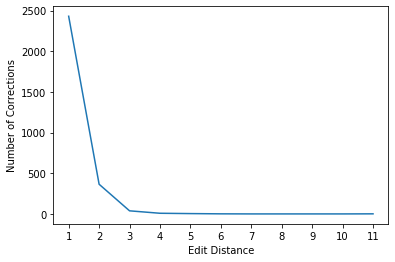

In [39]:
import matplotlib.pyplot as plt
import numpy as np

LIMIT = 12
ctr_dist = [0 for _ in range(LIMIT)]

# Iterate through all the mismatched spelling corrections.
for entry in errors_aspell:
    if errors_aspell[entry][1] in all_words:
        ctr_dist[get_min_edit_dist(entry, errors_aspell[entry][1])[0]] += 1

# Correct spelling corrections are of edit distance 1.
ctr_dist[1] += len(test_set_1) - len(errors_aspell)

ctr_dict = {}
for i in range(1, LIMIT):
    ctr_dict[i] = ctr_dist[i]

ctr_dict = sorted(ctr_dict.items())
x, y = zip(*ctr_dict)     
plt.plot(x, y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel('Edit Distance')
plt.ylabel('Number of Corrections')
plt.show()

### Beyond the Noisy Channel

The noisy channel model is a robust and highly extensible framework for spelling correction. It can account for a majority of virtually conceivable spelling errors, provided that the language and error models are comprehensive or sophisticated enough for the task at hand. As seen in the evaluation of the built model, a language model that is limited ultimately leads to subpar results. Nevertheless, one of the main advantages of the noisy channel model is its extensibility:
- Aside from the suggestions in **Section B** on expanding the corpus, context can be integrated to an extent in the language model by considering higher-order $n$-grams. For example, the most probable correction to `horor` in `maid of horor` is `honor` instead of `horror`, but this can only be captured by considering trigrams. The general idea to factor in context using an $n$-gram model is to imbue the Markov model with a bit more history.
- In **Section B**, it was also suggested that the error model can be extended through the incorporation of keyboard-based edit distances and phonetic information (e.g., the metaphone algorithm used by GNU Aspell). In brief, a spelling correction system may benefit from an ensemble of channel models.
- As suggested by Jurafsky and Martin (2021), the probability function itself may be modified to give a higher weight to either of the models, resulting in a modified formulation of the Bayesian inference: $P(c|w) = P(c) \times P(w|c)^\lambda$, where $\lambda$ is a parameter tuned via a dedicated development set. 

Despite these strengths, relying on the noisy channel model alone is inadequate. As already pointed out in Section 2, this approach is susceptible to overcorrection (although it can be partially mitigated with a blacklist). However, proper nouns or, more generally, named entities pose another problem. It is not entirely clear-cut as to whether they should be blacklisted or subjected to some form of spelling correction. For instance, `Philipines` is most likely a misspelling of `Philippines` and should be corrected. However, more uncommon spellings of people's names, like `Queenievere`, should ideally be preserved. 

Regardless of the design decision, this cannot be reliably done equipped with only a noisy channel model. Named entity recognition is a separate prototypical NLP task, and the example above shows the importance of integrating it in order to create a more accommodating spelling correction model. Specifically, a more granular approach where names of people are distinguished from established entities, like names of countries and geographical locations, may prove to be helpful. To further illustrate this point, consider the output of the built backoff-based model when our names are entered. 

In [40]:
spell_correction_backoff('Phoebe')

Minimum Edit Distance of 1
['phoebe', 'Phebe'] 



In [41]:
spell_correction_backoff('Mark')

Minimum Edit Distance of 1
Output: No error 



In [42]:
spell_correction_backoff('Hylene')

Minimum Edit Distance of 1
[] 

Minimum Edit Distance of 2
['Cyrene', 'Hymen', 'Hyena', 'Syene', 'Hilen', 'Hygiene', 'Helena', 'Hymenee'] 



Additional complications arise when dealing with spaces. Even though Norvig's list of spelling corrections included rules for substituting characters for spaces (e.g., ` |r`), the built model is restricted to single-word inputs and outputs. More powerful spelling models ideally should be able to handle corrections like `langu age` to `language` (deletion of a space) and `ofthe` to `of the` (insertion of a space). Although it is possible to incorporate this into the existing noisy channel model by considering word-pairs (or word-tuples) instead of single words, this introduces an additional layer of complexity and computational cost that may not be commensurate with its performance, reducing the applicability of the noisy channel model with respect to this particular class of problems.

An intuitive way to address this issue with word boundaries is through a method that is able to "natively" handle sequences. This has motivated researchers to explore a special class of finite state automata known as weighted finite-state transducers ([Riley, Allauzen & Jansche, 2009](https://aclanthology.org/N09-4005/)). The code segment below highlights this problem in the existing model.

In [43]:
spell_correction_backoff('ofthe')

Minimum Edit Distance of 1
[] 

Minimum Edit Distance of 2
['the', 'other', 'often', 'oath', 'oft', 'bathe', 'soothe', 'tithe', 'oaths', 'lithe', 'lothe', 'Lethe', 'loathe', 'afther', 'Afther', 'Goethe', 'sithe', 'tythe', 'Lithe', 'Soothe', 'Bathe'] 



Finally, in light of the advancements in machine learning and deep learning, spelling correction models can learn the error model instead of relying on a predefined set of rules. Interestingly, one of the most influential papers on the application of the noisy channel model to spelling correction, i.e., the paper written by [Kernighan, Church, and Gale (1990)](https://aclanthology.org/C90-2036/), is patterned after the same idea, as it iteratively constructs the confusion matrices using the expectation-maximization (EM) algorithm. A more recent work is the Chinese spell correction program by [Han, Lv, Wang, and Fu (2019)](https://colips.org/conferences/ialp2019/ialp2019.com/files/papers/IALP2019_094.pdf), which exploits a bidirectional long short-term memory network (BiLSTM) to automatically learn errors, reframing it into a sequence labeling task. 

[Hládek, Staš, and Pleva (2020)](https://www.mdpi.com/2079-9292/9/10/1670) note that studies following this approach either forgo the use of a language model or use a separately trained embedding. An example of the latter is the work of [Fivez, Suster, and Daelemans (2017)](https://aclanthology.org/W17-2317.pdf), which employs a fastText skipgram model &mdash; making it considerably more context-sensitive than simply considering higher $n$-grams for the language model. On a more general note, this approach also ties spelling correction to the NLP1000 lesson on vector semantics and embeddings. 

This suggests that, although orthography scratches only the "shallower" tiers of language processing while semantics belongs to a "deeper" level, they have an interesting connection that leads to the mutual enrichment of works on both areas. Ultimately, this paints a more nuanced and unified picture of natural language processing and opens up promising intersections for future directions in improving automatic spelling correction systems.

<hr>

# References

- Aspell. (n.d.). *Lawrence Philips' metaphone algorithm*. GNU Aspell. http://aspell.net/metaphone/
- Fivez, P., Suster, S., & Daelemans, W. (2017). Unsupervised context-sensitive spelling correction of clinical free-text with word and character n-gram embeddings. In *Proceedings of the BioNLP 2017 Workshop,* 143-148.
- Jurafsky, D., & Martin, J.H. (2021). *Speech and language processing* (3rd ed., draft). Stanford University.
- Kernighan, M.D., Church, K.W., & Gale, W.A. (1990). A spelling correction program based on a noisy channel model. In *COLING 1990 Volume 2: Papers presented to the 13th International Conference on Computational Linguistics*.
- Han, Z., Lv, C., Wang, Q., & Fu, G. (2019). Chinese spelling check based on sequence labeling. In *2019 International Conference on Asian Language Processing (IALP),* 373-378. doi: 10.1109/IALP48816.2019.9037652.
- Hládek, D, Staš, J, & Pleva, M. (2020). Survey of automatic spelling correction. *Electronics, 9*(10), 1670.
- Lai, K.H., Topaz, M., Gross, F.R., & Zhou, L. (2015). Automated misspelling detection and correction in clinical free-text records. *Journal of Biomedical Informatics, 55*, 188-195.
- Mykowiecka, A., & Marciniak, M. (2006). Domain-driven automatic spelling correction for mammography reports. In M.A. Kłopotek, S.T. Wierzchoń, & K. Trojanowski (Eds.), *Intelligent information processing and web mining*. Springer.
- Riley, M., Allauzen, C., & Jansche, M. (2009). OpenFst: An open-source, weighted finite-state transducer library and its applications to speech and language. In *Proceedings of Human Language Technologies: The 2009 Annual Conference of the North American Chapter of the Association for Computational Linguistics, Companion Volume: Tutorial Abstracts*, 9- 10.
- Rudra, A. (2007). *Lecture 8: Shannon's noise models.* University at Buffalo. https://cse.buffalo.edu/faculty/atri/courses/coding-theory/lectures/lect8.pdf
- Sagar-Fenton, B., & McNeill, L. (2018, June 24). *How many words do you need to speak a language?* BBC News. https://www.bbc.com/news/world-44569277
- Sha, S., Jun, L., Qinghua, Z., & Wei, Z. (2011). Automatic Chinese topic term spelling correction in online Pinyin input. In *Proceedings of the International Conference on Human-centric Computing 2011 and Embedded and Multimedia Computing 2011*, 23-36.
- Whitelaw, C., Hutchinson, B., Chung, G.Y., & Ellis, G. (2009). Using the web for language independent spellchecking and autocorrection. In *EMNLP '09: Proceedings of the 2009 Conference on Empirical Methods in Natural Language Processing: Volume 2*, 890-899.
- Wikipedia. (2022). *Wikipedia:Statistics*. https://en.wikipedia.org/wiki/Wikipedia:Statistics
